In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from time import process_time

In [0]:
Test_data = pd.read_csv('/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/Fashion-MNIST/Reduced_Test_Data.csv', header = None)
Test_label = pd.read_csv('/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/Fashion-MNIST/testLabels.csv', header = None)
Train_data = pd.read_csv('/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/Fashion-MNIST/Reduced_Train_Data.csv', header = None)
Train_label = pd.read_csv('/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/Fashion-MNIST/trainLabels.csv', header = None)

In [0]:
Test_data = Test_data.to_numpy()
Test_label = Test_label.to_numpy()
Train_data = Train_data.to_numpy()
Train_label = Train_label.to_numpy()

The Noise are added here

In [0]:
noise = np.random.normal(loc=0.0, scale=0.2, size=(Train_data.shape))
Train_data = Train_data + noise

In [0]:
maxD = np.max(Train_data, axis=0)
minD = np.min(Train_data, axis=0)
delta = maxD - minD
Train_data = Train_data - minD
Test_data = Test_data - minD
Train_data = 2 * (Train_data/delta) - 1
Test_data = 2 * (Test_data/delta) - 1

In [0]:
def relu(x):
  return np.maximum(x, np.zeros_like(x))

def Cal_accuracy(True_label, Estimated_label):
  return np.count_nonzero(np.transpose(True_label)==np.array(Estimated_label))/True_label.size

def step(x):
  return 1*(x > np.zeros_like(x))

def encode(vect, idx, landa):
  temp = np.multiply(step(landa - vect),-1)
  temp[idx] = 1
  return temp

def gelu(x):
    return 0.5 * np.multiply(x, 1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))

def Dgelu(x):
  return np.divide(0.053516 * np.power(x, 3) + np.multiply(0.398942, x) , np.power(np.cosh(0.0356774 * np.power(x, 3) +np.multiply(0.79788, x)),2)) + 0.5 * ( 1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))

def RBF_encode(data, number_class, dim):
  data = np.reshape(data, (dim,int(data.size/dim)), order='F')
  data = LA.norm(data,1, axis = 0)
  data = np.reshape(data, (number_class, int(data.size/number_class)), order='F')
  return data

def expand(x):
  temp = []
  for i in range(len(x)):
    temp.append(x[i])
    temp.append(x[i])
  return temp

In [0]:
class Network:
  def __init__(self, input_node, hidden_layer, hidden_node, output_node):
    self.number_input_node = input_node
    self.number_hidden_layer = hidden_layer
    self.number_hidden_node = hidden_node
    self.number_class_output = output_node
    self.distance_dim = 2
    self.weight = {}
    self.layer = {}
    self.batch_data = {}
    self.batch_label = {}
    self.diff_weight = {}
    self.score = []
    self.result = []
    self.init_weight()
    self.loss = []
    self.back_prob_output = []
    for i in range(self.number_hidden_layer + 1):
      self.diff_weight["w" + str(i) + "_prev"] = 0
      self.diff_weight["b" + str(i) + "_prev"] = 0
    self.momentum = 0.9
    self.learning_rate = 0.001
    self.number_turn = 100
    self.batchS = 128
    self.accuracy_graph = []
    self.loss_graph = []
    self.landa = 550
    self.accuracy_graph_epoch = []

  def set_turn(self, x):
    self.number_turn = x

  def set_learning_rate(self, x):
    self.learning_rate = x

  def set_batch_size(self, x):
    self.batchS = x
  
  def load_weights(self):
    for i in range(self.number_hidden_layer + 1):
      self.weight["w" + str(i)] = (pd.read_csv("/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/Fashion-MNIST/w" + str(i) + ".csv", header=None)).to_numpy()
      self.weight["b" + str(i)] = (pd.read_csv("/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/Fashion-MNIST/b" + str(i) + ".csv", header=None)).to_numpy()

  def init_weight(self):
    self.weight["w0"] = np.random.normal(loc=0, scale=0.14, size=(self.number_hidden_node[0], self.number_input_node))
    self.weight["b0"] = np.random.normal(loc=0, scale=0.14, size=(self.number_hidden_node[0], 1))
    for i in range(self.number_hidden_layer - 1):
      self.weight["w" + str(i+1)] = (np.random.normal(loc=0, scale=0.14, size=(self.number_hidden_node[i+1], self.number_hidden_node[i])))
      self.weight["b" + str(i+1)] = (np.random.normal(loc=0, scale=0.14, size=(self.number_hidden_node[i+1], 1)))
    self.weight["w" + str(self.number_hidden_layer)] = np.random.normal(loc=0, scale=0.14, size=(self.number_class_output * self.distance_dim, self.number_hidden_node[self.number_hidden_layer-1]))
    self.weight["b" + str(self.number_hidden_layer)] = np.random.normal(loc=0, scale=0.14, size=(self.number_class_output * self.distance_dim, 1))
    
  def forward(self, data):
    self.layer.clear()
    self.layer["input"] = data
    if len(data) == data.size:
      self.layer["z0"] = (np.matmul(self.weight["w0"],np.transpose(data))).reshape((len(MyNetwork.weight["w0"]),self.batchS))
    else:
      self.layer["z0"] = (np.matmul(self.weight["w0"], np.transpose(data)))
    self.layer["z0"] = np.add(self.layer["z0"], self.weight["b0"])
    self.layer["r0"] = gelu(self.layer["z0"])
    self.layer["s0"] = Dgelu(self.layer["z0"])
    for i in range(self.number_hidden_layer - 1):
      self.layer["z" + str(i + 1)] = np.matmul(self.weight["w" + str(i + 1)], self.layer["r" + str(i)])
      self.layer["z" + str(i + 1)] = np.add(self.layer["z" + str(i + 1)], self.weight["b" + str(i+1)])
      self.layer["r" + str(i + 1)] = gelu(self.layer["z" + str(i + 1)])
      self.layer["s" + str(i + 1)] = Dgelu(self.layer["z" + str(i + 1)])
    self.layer["z" + str(self.number_hidden_layer)] = np.matmul(self.weight["w" + str(self.number_hidden_layer)], self.layer["r" + str(self.number_hidden_layer - 1)])
    self.layer["z" + str(self.number_hidden_layer)] = np.add(self.layer["z" + str(self.number_hidden_layer)], self.weight["b" + str(self.number_hidden_layer)])
    self.layer["r" + str(self.number_hidden_layer)] = RBF_encode(self.layer["z" + str(self.number_hidden_layer)], self.number_class_output, self.distance_dim)
    self.layer["s" + str(self.number_hidden_layer)] = np.sign(self.layer["z" + str(self.number_hidden_layer)])
    self.score = self.layer["r" + str(self.number_hidden_layer)]
    temp = self.decide_RBF(self.score)
    return temp
  
  def decide_RBF(self, data):
    self.result = np.argmin(data, axis=0)
    return self.result

  def cal_loss(self, label):
    self.loss.clear()
    self.back_prob_output = []
    temp = np.transpose(self.score)
    for i in range(len(label)):
      self.loss.append(np.sum(relu((self.landa - temp[i]))) - relu(self.landa- temp[i][label[i]]) + temp[i][label[i]])
      self.back_prob_output.append(encode(temp[i], label[i], self.landa))
    self.back_prob_output = np.transpose(self.back_prob_output)/len(label)
    total_loss = np.sum(self.loss)/len(self.loss)
    self.loss_graph.append(total_loss)
    return total_loss

  def batching(self, data, label):
    batch_size = self.batchS
    if len(data) == data.size:
      batch[0] = data
      return
    for i in range(int(len(data)/batch_size)):
      self.batch_data[i] = data[i*batch_size:(i+1)*batch_size]
      self.batch_label[i] = label[i*batch_size:(i+1)*batch_size]
    if len(data)%batch_size != 0:
      self.batch_data[int(len(data)/batch_size)] = data[int(len(data)/batch_size)*batch_size:len(data)]
      self.batch_label[int(len(data)/batch_size)] = label[int(len(data)/batch_size)*batch_size:len(data)]

  def back_prob(self):
    temp = np.multiply(expand(self.back_prob_output), self.layer["s" + str(self.number_hidden_layer)])
    for i in range(self.number_hidden_layer):
      self.diff_weight["w" + str(self.number_hidden_layer - i)] = np.matmul(temp, np.transpose(self.layer["r"+ str(self.number_hidden_layer-1-i)]))
      self.diff_weight["b" + str(self.number_hidden_layer - i)] = np.matmul(temp, np.ones((len(temp[0]), 1)))
      temp = np.matmul(np.transpose(self.weight["w" + str(self.number_hidden_layer - i)]), temp)
      temp = np.multiply(self.layer["s" + str(self.number_hidden_layer - i - 1)], temp)
    self.diff_weight["w0"] = np.matmul(temp, self.layer["input"])
    self.diff_weight["b0"] = np.matmul(temp, np.ones((len(temp[0]), 1)))

    for i in range(self.number_hidden_layer + 1):
      self.diff_weight["w" + str(i) + "_prev"] = ((1 - self.momentum) * self.diff_weight["w" + str(i)] + self.momentum * self.diff_weight["w" + str(i) + "_prev"])
      self.diff_weight["b" + str(i) + "_prev"] = ((1 - self.momentum) * self.diff_weight["b" + str(i)] + self.momentum * self.diff_weight["b" + str(i) + "_prev"])

    for i in range(self.number_hidden_layer + 1):
      self.weight["w" + str(i)] = self.weight["w" + str(i)] - self.diff_weight["w" + str(i) + "_prev"] * self.learning_rate
      self.weight["b" + str(i)] = self.weight["b" + str(i)] - self.diff_weight["b" + str(i) + "_prev"] * self.learning_rate

  def Train_Network(self, data, label):
    epoch = 0
    for j in range(self.number_turn):
      self.batching(data, label)
      for i in range(len(self.batch_data)):
        self.forward(self.batch_data[i])
        self.accuracy_graph.append(Cal_accuracy(self.batch_label[i], self.forward(self.batch_data[i])))
        print(self.cal_loss(self.batch_label[i]), " step ", i," of the epoch ", j , "the steps is: ", epoch)
        self.back_prob()
        epoch += 1
      self.accuracy_graph_epoch.append((self.Test_Network(data, label)))

  def Test_Network(self, data, label):
    if(len(data) == data.size):
      temp = self.batchS
      self.batchS = 1
      print(Cal_accuracy(label, MyNetwork.forward(data)))
      self.batchS = temp
    else:
      print(Cal_accuracy(label, MyNetwork.forward(data)))
    return (Cal_accuracy(label, MyNetwork.forward(data)))
     

In [0]:
MyNetwork = Network(128,1,[150],10)
MyNetwork.set_learning_rate(0.01)
MyNetwork.set_turn(20)
MyNetwork.set_batch_size(128)
start = process_time()
MyNetwork.Train_Network(Train_data, Train_label)
print('time of train :', process_time()-start)

4945.946305611696  step  0  of the epoch  0 the steps is:  0
4945.977705697809  step  1  of the epoch  0 the steps is:  1
4945.899944617888  step  2  of the epoch  0 the steps is:  2
4945.9617716408975  step  3  of the epoch  0 the steps is:  3
4945.872911246728  step  4  of the epoch  0 the steps is:  4
4945.757612636076  step  5  of the epoch  0 the steps is:  5
4945.543438940738  step  6  of the epoch  0 the steps is:  6
4945.614591627251  step  7  of the epoch  0 the steps is:  7
4945.4579956008565  step  8  of the epoch  0 the steps is:  8
4945.25045555417  step  9  of the epoch  0 the steps is:  9
4945.38058059102  step  10  of the epoch  0 the steps is:  10
4944.910836870419  step  11  of the epoch  0 the steps is:  11
4944.86750741074  step  12  of the epoch  0 the steps is:  12
4944.56419845289  step  13  of the epoch  0 the steps is:  13
4944.186139984686  step  14  of the epoch  0 the steps is:  14
4944.240481477997  step  15  of the epoch  0 the steps is:  15
4943.874603946

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in power


2652.2499544823268  step  102  of the epoch  0 the steps is:  102
2517.65317127196  step  103  of the epoch  0 the steps is:  103
2276.294660231523  step  104  of the epoch  0 the steps is:  104
2112.7449645266347  step  105  of the epoch  0 the steps is:  105
1891.297816850083  step  106  of the epoch  0 the steps is:  106
1656.420652328501  step  107  of the epoch  0 the steps is:  107


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in cosh


Streaming output truncated to the last 5000 lines.
378.87202228019726  step  172  of the epoch  9 the steps is:  4393
368.24768966976296  step  173  of the epoch  9 the steps is:  4394
379.0734099678351  step  174  of the epoch  9 the steps is:  4395
365.0484317914262  step  175  of the epoch  9 the steps is:  4396
391.5215605981426  step  176  of the epoch  9 the steps is:  4397
326.3721039380787  step  177  of the epoch  9 the steps is:  4398
363.87751948287007  step  178  of the epoch  9 the steps is:  4399
383.45920465243364  step  179  of the epoch  9 the steps is:  4400
374.3187995407973  step  180  of the epoch  9 the steps is:  4401
379.24662379153835  step  181  of the epoch  9 the steps is:  4402
360.7871851183937  step  182  of the epoch  9 the steps is:  4403
360.97409415155823  step  183  of the epoch  9 the steps is:  4404
389.9625934942203  step  184  of the epoch  9 the steps is:  4405
386.23146043629094  step  185  of the epoch  9 the steps is:  4406
337.6484169469196 

In [0]:
MyNetwork.Test_Network(Test_data, Test_label)
MyNetwork.Test_Network(Train_data, Train_label)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in power


0.8396
0.8532166666666666


0.8532166666666666

In [0]:
start = process_time()
MyNetwork.Train_Network(Train_data, Train_label)
print('time of train :', process_time()-start)

173.81227154291855  step  0  of the epoch  0 the steps is:  0
218.69661484028023  step  1  of the epoch  0 the steps is:  1
229.8520219406526  step  2  of the epoch  0 the steps is:  2
213.6819909298403  step  3  of the epoch  0 the steps is:  3
236.63947899991797  step  4  of the epoch  0 the steps is:  4
189.91207324752477  step  5  of the epoch  0 the steps is:  5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in power


191.71373863620698  step  6  of the epoch  0 the steps is:  6
228.70037805259733  step  7  of the epoch  0 the steps is:  7
244.05599515785858  step  8  of the epoch  0 the steps is:  8
251.59999761455714  step  9  of the epoch  0 the steps is:  9
208.69986762884054  step  10  of the epoch  0 the steps is:  10
195.64659490234123  step  11  of the epoch  0 the steps is:  11
172.3619498549008  step  12  of the epoch  0 the steps is:  12
182.48368872141816  step  13  of the epoch  0 the steps is:  13
251.1738177877933  step  14  of the epoch  0 the steps is:  14
220.96963561159117  step  15  of the epoch  0 the steps is:  15
253.3850004785046  step  16  of the epoch  0 the steps is:  16
218.53206959779288  step  17  of the epoch  0 the steps is:  17
219.41063541330217  step  18  of the epoch  0 the steps is:  18
192.67522646722432  step  19  of the epoch  0 the steps is:  19
251.2435557710213  step  20  of the epoch  0 the steps is:  20
233.67084765463798  step  21  of the epoch  0 the st

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in cosh


0.8648333333333333
157.39404988801186  step  0  of the epoch  5 the steps is:  2345
200.56471133388766  step  1  of the epoch  5 the steps is:  2346
213.15020882413765  step  2  of the epoch  5 the steps is:  2347
196.18848599069298  step  3  of the epoch  5 the steps is:  2348
214.35532324557443  step  4  of the epoch  5 the steps is:  2349
171.1371675779664  step  5  of the epoch  5 the steps is:  2350
180.0562921717726  step  6  of the epoch  5 the steps is:  2351
214.186212093725  step  7  of the epoch  5 the steps is:  2352
225.49021429594876  step  8  of the epoch  5 the steps is:  2353
235.30679024727903  step  9  of the epoch  5 the steps is:  2354
193.56570005731288  step  10  of the epoch  5 the steps is:  2355
170.088092474049  step  11  of the epoch  5 the steps is:  2356
157.84263169889869  step  12  of the epoch  5 the steps is:  2357
165.53053368702624  step  13  of the epoch  5 the steps is:  2358
234.41304202790718  step  14  of the epoch  5 the steps is:  2359
194.210

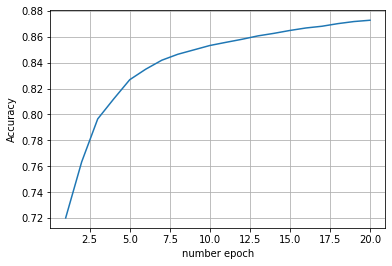

In [0]:
plt.plot(np.arange(1,len(MyNetwork.accuracy_graph_epoch)+1), MyNetwork.accuracy_graph_epoch)
plt.ylabel('Accuracy')
plt.xlabel("number epoch")
plt.grid(True)
plt.show()


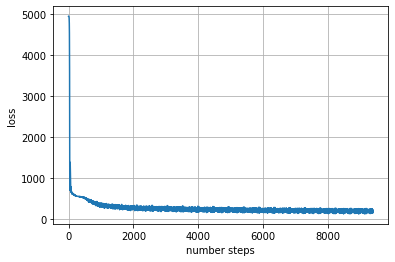

In [0]:
plt.plot(np.arange(1,len(MyNetwork.loss_graph)+1), MyNetwork.loss_graph)
plt.ylabel('loss')
plt.xlabel("number steps")
plt.grid(True)
plt.show()

In [0]:
for i in range(MyNetwork.number_hidden_layer + 1):
  pd.DataFrame(MyNetwork.weight["w" + str(i)]).to_csv("/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/Fashion-MNIST/w" + str(i) + ".csv", index=False, header=False)
  pd.DataFrame(MyNetwork.weight["b" + str(i)]).to_csv("/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/Fashion-MNIST/b" + str(i) + ".csv", index=False, header=False)
  pd.DataFrame(MyNetwork.accuracy_graph).to_csv("/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/Fashion-MNIST/accuracy.csv", index=False, header=False)
  pd.DataFrame(MyNetwork.loss_graph).to_csv("/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/Fashion-MNIST/loss.csv", index=False, header=False)
